In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl
# import cmocean

In [2]:
AllData = pd.read_csv('./dataFolders/compiledTrackData.csv')
circ_params = pd.read_csv('./dataFolders/circle_parameters.csv')
outfig = './dataFolders/Figures/Angle'

In [3]:
p1 = pd.Series(data = None, index = AllData.index, name = 'angle', dtype = 'float64')
AllData = pd.concat([AllData, p1], axis = 1)
AllData.head()

,Unnamed: 0,name,trial,xpts,ypts,radius,theta,angle
0,0,c-1_m13,0,NaN,NaN,NaN,NaN,NaN
1,1,c-1_m13,0,5.011057,348.049824,321.678510,160.373100,NaN
2,2,c-1_m13,0,20.932432,335.463658,302.524542,161.605573,NaN
3,3,c-1_m13,0,40.568796,325.165885,280.664705,162.335453,NaN
4,4,c-1_m13,0,50.652334,323.449590,270.539563,162.033785,NaN


In [4]:
names = AllData.name.unique()

In [5]:
def Unitvector(x_gauss, y_gauss):
    from sklearn import preprocessing
    
    # get the slope of the tangent
    trajectory = np.asarray([x_gauss, y_gauss])
    m = np.gradient(trajectory, axis = 1)
    m_atx = m[1]/m[0]
    
    # get the tangent vector at x = x0 + 1
    tangent_x = x_gauss+1
    tangent_y = m_atx + y_gauss
    
    # get the unit tangent vector
    u_x = []
    u_y = []

    for x,y,x0,y0 in zip(tangent_x, tangent_y, x_gauss, y_gauss):
        if np.any(np.isnan([x, y])) or np.any(np.isinf([x, y])):
            unit_x = np.nan
            unit_y = np.nan
        else:
            vector = np.asarray([x-x0, y-y0]).reshape(1,-1)
            [unit_x, unit_y] = preprocessing.normalize(vector, norm = 'l2')[0]
        u_x.append(unit_x)
        u_y.append(unit_y)
    u_x = np.asarray(u_x)
    u_y = np.asarray(u_y)
    return(u_x, u_y)

In [6]:
def getAngle(loc, tangent):
    cross = np.cross(tangent, loc)
    dot = np.dot(tangent, loc)
    angle = np.arctan2(cross, dot)*180/np.pi
    return(angle)

In [30]:
def angleCorloredTrajectory(x_gauss, y_gauss, angle):
    
    fig = plt.subplots(figsize = (5,5))
    plt.scatter(x_gauss, y_gauss, s=7 , c = angle, cmap = plt.cm.jet)
    c1 = plt.Circle((0, 0), circ_r, facecolor='grey', alpha=0.3, edgecolor='none')
    ax = plt.gca()
    ax.add_artist(c1)
    ax.set_aspect('equal', adjustable = 'datalim')
    cbar = plt.colorbar()
    
    return(fig)

In [118]:
def angleColoredSweepCurves(r_gauss, circ_r, angle):
    fig = plt.subplots(figsize = (5,5))
    t0 = np.arange(len(r_gauss))*1/100
    plt.scatter(t0, r_gauss/circ_r, s = 10,
                c = angle, cmap = plt.cm.jet)
    cbar = plt.colorbar()
    return(fig)

In [32]:
for name in names:
    # get the circle parameters
    circ_x = circ_params.circ_x[circ_params.name == name].values
    circ_y = circ_params.circ_y[circ_params.name == name].values
    circ_r = circ_params.circ_radii[circ_params.name == name].values

    trial = ['0', 'last']
    for trial in trial:
        x = AllData[(AllData.name == name) & (AllData.trial == trial)].xpts.values
        y = AllData[(AllData.name == name) & (AllData.trial == trial)].ypts.values
        
        # center the x and y coordinates
        cent_x = x - circ_x
        cent_y = y - circ_y
        
        win_gauss = signal.gaussian(10,3)
        x_gauss = signal.convolve(cent_x, win_gauss, 
                                  mode='same', method = 'direct') / win_gauss.sum()
        y_gauss = signal.convolve(cent_y, win_gauss, 
                                  mode = 'same', method = 'direct') / win_gauss.sum()
        
        r = np.linalg.norm([cent_x, cent_y], axis = 0)
        r_gauss = np.linalg.norm([x_gauss, y_gauss], axis = 0)

        
        #calculate the unit tangent vectors
        u_x, u_y = Unitvector(x_gauss, y_gauss)
        
        angle = []
        for x0, y0, x, y in zip(x_gauss, y_gauss, u_x, u_y):
            loc = [x0, y0]
            tangent = [x, y]
            a = getAngle(loc, tangent)
            angle.append(a)

        angle = np.absolute(angle)
        for i,a in enumerate(angle):
            if a > 90:
                a = 180 - a
                angle[i] = a
        
        
        AllData.loc[(AllData.name == name) & (AllData.trial == trial), 'angle'] = angle
        
        f1, _ = angleCorloredTrajectory(x_gauss, y_gauss, angle)
        f2, _ = angleColoredSweepCurves(r_gauss, circ_r, angle)
        
        f1.savefig(outfig + '//angleTrajectory_' + name + '_trial_' + trial + '.png')
        f2.savefig(outfig + '//angleSweep_' + name + '_' + trial + '.png')
        f1.clf()
        f2.clf()
        plt.close('all')

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [28]:
AllData.loc[(AllData.name == name) & (AllData.trial == trial), 'angle'] = angle

In [29]:
np.any(AllData.angle.notnull())

True

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


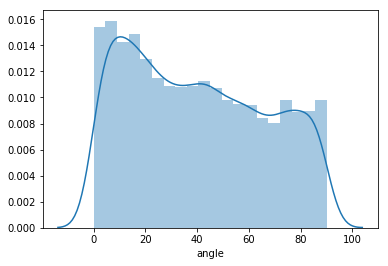

In [33]:
import seaborn as sns
sns.distplot(AllData[AllData.angle.notnull()].angle)

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is

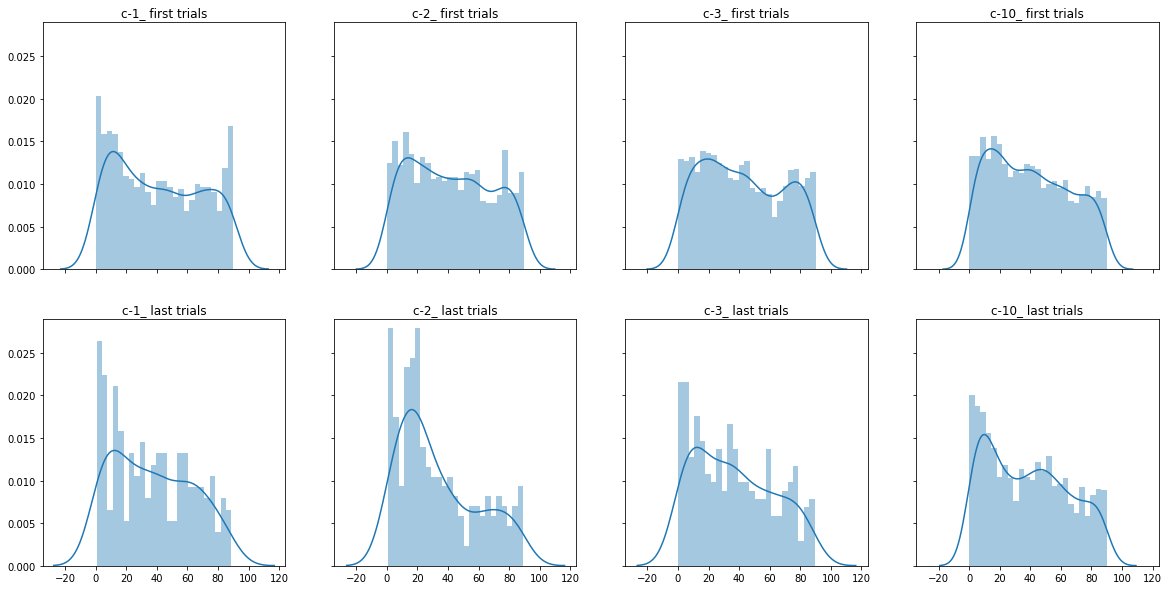

In [90]:
fig, ax = plt.subplots(2,4, figsize = (20,10), sharex = True, sharey = True)
ax = ax.ravel()

shapes = ['c-1_', 'c-2_', 'c-3_', 'c-10_']
bins = 25

for i, shape in enumerate(shapes):
    subset = AllData.loc[(AllData.name.str.contains(shape)) & 
                         (AllData.trial == '0'), 'angle'].values
    subset = subset[~np.isnan(subset)]
    sns.distplot(subset, ax = ax[i], bins = bins)
    ax[i].set_title(shape + ' first trials')
    
    subset = AllData.loc[(AllData.name.str.contains(shape)) & 
                         (AllData.trial == 'last'), 'angle'].values
    subset = subset[~np.isnan(subset)]
    sns.distplot(subset, ax = ax[i + 4], bins = bins)
    ax[i + 4].set_title(shape + ' last trials')
    
ax[i].set_ylim([0, 0.029])
fig.savefig(outfig + '//angleDistributions.png')

In [109]:
kstest_matrix_first = pd.DataFrame(data = None, columns = shapes, index = shapes)

In [110]:
from scipy import stats

combinations = [(x,y) for x in shapes for y in shapes]
for x,y in combinations:
    
    subset1 = AllData.loc[(AllData.name.str.contains(x)) & 
                         (AllData.trial == '0'), 'angle'].values    
    subset1 = subset1[~np.isnan(subset1)]
    
    subset2 = AllData.loc[(AllData.name.str.contains(y)) & 
                         (AllData.trial == '0'), 'angle'].values
    subset2 = subset2[~np.isnan(subset2)]
    
    D, pvalue = stats.ks_2samp(subset1, subset2)
    kstest_matrix_first.loc[x,y] = pvalue

In [111]:
kstest_matrix_first

,c-1_,c-2_,c-3_,c-10_
c-1_,1,0.0792343,0.0144132,0.0648945
c-2_,0.0792343,1,0.803209,0.128433
c-3_,0.0144132,0.803209,1,0.0198752
c-10_,0.0648945,0.128433,0.0198752,1


In [102]:
kstest_matrix_last = pd.DataFrame(data = None, columns = shapes, index = shapes)

combinations = [(x,y) for x in shapes for y in shapes]
for x,y in combinations:
    
    subset1 = AllData.loc[(AllData.name.str.contains(x)) & 
                         (AllData.trial == 'last'), 'angle'].values    
    subset1 = subset1[~np.isnan(subset1)]
    
    subset2 = AllData.loc[(AllData.name.str.contains(y)) & 
                         (AllData.trial == 'last'), 'angle'].values
    subset2 = subset2[~np.isnan(subset2)]
    
    D, pvalue = stats.ks_2samp(subset1, subset2)
    kstest_matrix_last.loc[x,y] = pvalue
kstest_matrix_last

,c-1_,c-2_,c-3_,c-10_
c-1_,1,0.0323431,0.959762,0.895466
c-2_,0.0323431,1,0.0162931,0.000353001
c-3_,0.959762,0.0162931,1,0.362108
c-10_,0.895466,0.000353001,0.362108,1


In [117]:
kstest_matrix_first2last = pd.DataFrame(data = None, columns = ['first-last'], index = shapes)

for x in shapes:
    
    subset1 = AllData.loc[(AllData.name.str.contains(x)) & 
                         (AllData.trial == '0'), 'angle'].values    
    subset1 = subset1[~np.isnan(subset1)]
    
    subset2 = AllData.loc[(AllData.name.str.contains(x)) & 
                         (AllData.trial == 'last'), 'angle'].values
    subset2 = subset2[~np.isnan(subset2)]
    
    D, pvalue = stats.ks_2samp(subset1, subset2)
    kstest_matrix_first2last.loc[x,'first-last'] = pvalue
kstest_matrix_first2last

,first-last
c-1_,0.116353
c-2_,6.28743e-07
c-3_,0.0147897
c-10_,0.00098654


In [ ]:
plt.plot(cent_x)
plt.plot(x_gauss)

a = plt.axes([.5, .2, .3, .3])
plt.plot(cent_x[500:600])
plt.plot(x_gauss[500:600])
plt.show()

plt.plot(cent_y)
plt.plot(y_gauss)

a = plt.axes([.4, .65, .2, .2])
plt.plot(cent_y[400:500])
plt.plot(y_gauss[400:500])
plt.show()

In [ ]:
plt.plot(cent_x, cent_y)
plt.plot(x_gauss, y_gauss)

In [ ]:
r = np.linalg.norm([cent_x, cent_y], axis = 0)
r_gauss = np.linalg.norm([x_gauss, y_gauss], axis = 0)

plt.plot(r/circ_r)
plt.plot(r_gauss/circ_r)

In [ ]:
u_x, u_y = Unitvector(x_gauss, y_gauss)

# plt.style.use('default')
strt=300
stp=320
x = x_gauss[strt:stp]
y = y_gauss[strt:stp]
x_end = u_x[strt: stp]
y_end = u_y[strt:stp]
plt.plot(x,y, 'o-.')
plt.plot(x[0], y[0], 'o' ,color = 'k')
for x0, y0, x_dash, y_dash in zip(x, y, x_end, y_end):
    plt.arrow(x0, y0, x_dash, y_dash)

In [ ]:
# test_loc = [3,0]
# test_tang = [1,1]
# getAngle(test_loc, test_tang)

In [ ]:
angle = []
for x0, y0, x, y in zip(x_gauss, y_gauss, u_x, u_y):
    loc = [x0, y0]
    tangent = [x, y]
    a = getAngle(loc, tangent)
    angle.append(a)

angle = np.absolute(angle)
for i,a in enumerate(angle):
    if a > 90:
        a = 180 - a
        angle[i] = a
    
# working_angle = np.absolute(angle)
# np.place(working_angle, working_angle>90, 180-working_angle)
# working_angle = [ 180 - angle for angle in working_angle if angle > 90 ]

In [ ]:
fig = plt.subplots(figsize = (5,5))
plt.scatter(x_gauss, y_gauss, s=7 , c = angle, cmap = plt.cm.jet)
c1 = plt.Circle((0, 0), circ_r, color='grey', alpha=0.3, edgecolor='none')
ax = plt.gca()
ax.add_artist(c1)
ax.set_aspect('equal', adjustable = 'datalim')
cbar = plt.colorbar()

In [ ]:
fig = plt.subplots(figsize = (5,5))
t0 = np.arange(len(r_gauss))*1/100
plt.scatter(t0, r_gauss/circ_r, s = 10,
            c = angle, cmap = plt.cm.jet)
cbar = plt.colorbar()

In [ ]:
import seaborn as sns

angle = np.asarray(angle)
subset = angle[~np.isnan(angle)]
sns.distplot(np.absolute(subset))

In [ ]:
trajectory = np.asarray([x_gauss, y_gauss])
m = np.gradient(trajectory, axis = 1)
m_atx = m[1]/m[0]

In [ ]:
tangent_x = x_gauss+1
tangent_y = m_atx + y_gauss

u_x = []
u_y = []

from sklearn import preprocessing

for x,y,x0,y0 in zip(tangent_x, tangent_y, x_gauss, y_gauss):
#     print(x, y)
    if np.any(np.isnan([x, y])) or np.any(np.isinf([x, y])):
#         print('caught it')
        unit_x = np.nan
        unit_y = np.nan
    else:
        vector = np.asarray([x-x0, y-y0]).reshape(1,-1)
        [unit_x, unit_y] = preprocessing.normalize(vector, norm = 'l2')[0]
    u_x.append(unit_x)
    u_y.append(unit_y)

In [ ]:
# tangent_x = x_gauss+1
# tangent_y = m_atx + y_gauss

# # tangent = np.vstack((tangent_x, tangent_y))

# u_x = []
# u_y = []
# for x, y, y0 in zip(tangent_x, m_atx, y_gauss):
#     if x == np.nan or y == np.nan:
#         unit_x = np.nan
#         unit_y = np.nan
#     else:
#         norm = np.linalg.norm([1, y], axis = 0)
#         unit_x = x/norm
#         unit_y = y/norm
#     u_x.append(unit_x)
#     u_y.append(unit_y)